In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from scipy import stats
import requests
from requests import get
from bs4 import BeautifulSoup
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from linearmodels import PooledOLS
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from sklearn.decomposition import PCA
import prince
import mca
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.linear_model import LassoCV
from numpy import arange
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import meanabs
import statsmodels.api as sm

In [2]:
file = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/transaction.csv'
df_tr = pd.read_csv(file, header = None, index_col = 0)
df_tr.columns = ['type', 'from', 'to', 'date', 'punk_id', 'amount_in_eth', 'amount_in_dol']
df_tr = df_tr[ ['punk_id'] + [ col for col in df_tr.columns if col != 'punk_id' ] ]
df_tr.head()

,punk_id,type,from,to,date,amount_in_eth,amount_in_dol
0,,,,,,,
0,0,Bid Withdrawn,0x983ace,NaN,2021-05-10,250.0,1030000.0
1,0,Bid,0x983ace,NaN,2021-04-11,250.0,"537,615"
2,0,Bid Withdrawn,0xd7510a,NaN,2021-03-03,100.0,"160,973"
3,0,Bid,0xd7510a,NaN,2021-02-20,100.0,"188,897"
4,0,Bid Withdrawn,natealex,NaN,2020-09-16,69.0,"25,532"


In [3]:
def fix_df(x):
    x['punk_id'] = x['punk_id'].astype('category')
    x['type'] = x['type'].astype('category')
    x['from'] = x['from'].astype(str)
    x['to'] = x['to'].astype(str)
    x['date'] = pd.to_datetime(x['date'], format = '%Y.%m.%d')
    
    x['amount_in_eth'] = x['amount_in_eth'].astype(str)
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('Y', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('Z', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('M', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('T', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('B', '')
    x['amount_in_eth'] = x['amount_in_eth'].replace(',', '', regex=True)
    x['amount_in_eth'] = x['amount_in_eth'].astype(float)

    x['amount_in_dol'] = x['amount_in_dol'].astype(str)
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('Y', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('B', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('T', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('P', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('Z', '')
    x['amount_in_dol'] = x['amount_in_dol'].replace('<', '', regex=True)
    x['amount_in_dol'] = x['amount_in_dol'].replace(',', '', regex=True)
    x['amount_in_dol'] = x['amount_in_dol'].astype(float)
    
    x['amount_in_eth'] = x['amount_in_eth'].fillna(0)
    x['amount_in_dol'] = x['amount_in_dol'].fillna(0)

    return x

In [4]:
df_tr = fix_df(df_tr)

sales = df_tr[df_tr['type'].str.contains("Sold")].reset_index(drop=True)
sales = sales.drop(['from', 'to', 'type', 'amount_in_eth'], axis=1)
sales.head()

,punk_id,date,amount_in_dol
0,0,2018-11-30,2822.0
1,0,2017-07-07,386.0
2,0,2017-06-23,320.0
3,1,2020-11-30,36305.0
4,1,2019-04-06,5155.0


In [5]:
ids = sales.punk_id.unique().tolist()
punks = []
check = []
for i in ids:
    try:
        var = sales.loc[sales.punk_id==i,'amount_in_dol'].values[1]
    except IndexError:
        var_exists = 0
    else:
        var_exists = var
    punks.append(i)
    check.append(var_exists)

sec_sales = dict(zip(punks, check))

In [6]:
ids = sales.punk_id.unique().tolist()
punks = []
check = []
for i in ids:
    sale = sales.loc[sales.punk_id==i,'amount_in_dol'].values[0]
    punks.append(i)
    check.append(sale)

last_sale = dict(zip(punks, check))

In [7]:
df_last_sale = pd.DataFrame(last_sale.items())
dict_name={0:'punk_id', 1:  'last_sale'}
df_last_sale.rename(columns=dict_name,inplace=True)

In [8]:
df_sec_sale = pd.DataFrame(sec_sales.items())
dict_name={0:'punk_id', 1:  'sec_sale',}
df_sec_sale.rename(columns=dict_name,inplace=True)

In [9]:
df = pd.merge(df_last_sale, df_sec_sale, on="punk_id", how='left')
df

,punk_id,last_sale,sec_sale
0,0,2822.0,386.0
1,1,36305.0,5155.0
2,14,234.0,351.0
3,33,105.0,0.0
4,53,42803.0,26612.0
...,...,...,...
5586,9980,70.0,0.0
5587,9989,140.0,0.0
5588,9990,44981.0,0.0
5589,9997,169770.0,21062.0


In [10]:
file2 = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/accessories.csv'
df_acc = pd.read_csv(file2, header = None, sep='\n')
df_acc = df_acc[0].str.split(',', expand=True)
df_acc.drop(0, axis=1, inplace=True)

dict={1:'gender', 
      2:  'acc_1',
      3:'acc_2', 
      4: 'acc_3',
      5:'acc_4',
      6: 'acc_5',
      7:'acc_6',
      8:'acc_7'}
df_acc.rename(columns=dict,
          inplace=True)

In [11]:
types = df_acc['gender']
types_dummies = pd.get_dummies(types)
types_dummies['punk_id'] = types_dummies.index
types_dummies = types_dummies[ ['punk_id'] + [ col for col in types_dummies.columns if col != 'punk_id' ] ]

In [12]:
file3 = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/accessories_transformed_full.csv'
acc = pd.read_csv(file3, index_col = 0)
acc['punk_id'] = acc.index
acc = acc[ ['punk_id'] + [ col for col in acc.columns if col != 'punk_id' ] ]

In [13]:
df = pd.merge(df, types_dummies, on="punk_id", how='left')
df = pd.merge(df, acc, on="punk_id", how='left')

df = df.set_index(['punk_id'])
df = df.fillna(0)
df

,last_sale,sec_sale,Alien,Ape,Female,Male,Zombie,Beanie,Choker,Pilot Helmet,...,Regular Shades,Horned Rim Glasses,Big Shades,Nerd Glasses,Black Lipstick,Mole,Purple Lipstick,Hot Lipstick,Cigarette,Earring
punk_id,,,,,,,,,,,,,,,,,,,,,
0,2822.0,386.0,0,0,1,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,36305.0,5155.0,0,0,0,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,234.0,351.0,0,0,1,0,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
33,105.0,0.0,0,0,0,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,42803.0,26612.0,0,0,1,0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,70.0,0.0,0,0,1,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9989,140.0,0.0,0,0,1,0,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9990,44981.0,0.0,0,0,0,1,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
y = df['last_sale']
y = y.round(decimals=-2)

X = df.iloc[:,1:]
X['sec_sale'] = X['sec_sale'].round(decimals=-2)
X = X.astype(int)
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)

In [15]:
sm_reg = sm.OLS(y_train, X_train).fit()
print(sm_reg.summary())

                            OLS Regression Results                            
Dep. Variable:              last_sale   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     31.50
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:13:19   Log-Likelihood:                -51859.
No. Observations:                3913   AIC:                         1.039e+05
Df Residuals:                    3820   BIC:                         1.045e+05
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.884e+05 

In [16]:
y_pred = sm_reg.predict(X_test)
print('Mean Absolute Error:', meanabs(y_test, y_pred))
print('Root Mean Squared Error:', rmse(y_test, y_pred))

Mean Absolute Error: 35347.738735701205
Root Mean Squared Error: 129733.59000172261


In [41]:
y = df['last_sale']
y = y.round(decimals=-2)

X = df.iloc[:,1:]
X['sec_sale'] = X['sec_sale'].round(decimals=-2)
X = X.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)

sm_reg = LinearRegression()
sm_reg.fit(X_train, y_train)
y_pred = sm_reg.predict(X_test)

In [42]:
print('Result for Last Sale Regression \n')
print('Adjusted Rsquared Train: ', (1 - (1-sm_reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', sm_reg.score(X_test, y_test).round(decimals=3))
print('Adjusted Rsquared Test: ', (1 - (1-sm_reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(decimals=3))

Result for Last Sale Regression 

Adjusted Rsquared Train:  0.417
Test R^2:  -1.316
Adjusted Rsquared Test:  -1.452
Mean Absolute Error: 35347.739
Mean Squared Error: 16830804360.586
Root Mean Squared Error: 129733.59


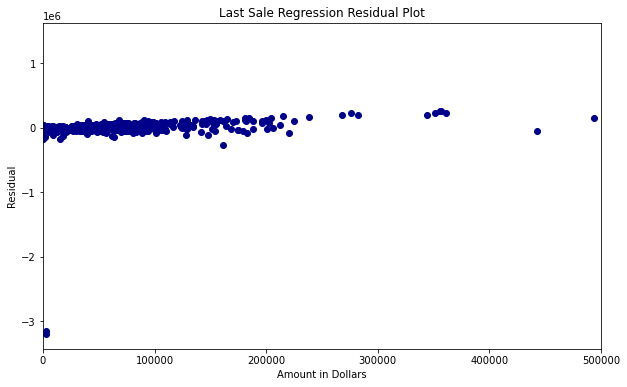

In [43]:
res = y_test - y_pred
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(y_test, res, 'o', color='darkblue')
plt.title("Last Sale Regression Residual Plot")
plt.xlabel("Amount in Dollars")
plt.ylabel("Residual")
plt.xlim(0, 500000)
plt.savefig('Last Sale Regression Residual Plot', transparent=True)
plt.show()
plt.close()

# Last Sale Reg with Selected Columns

In [34]:
y = df['last_sale']
y = y.round(decimals=-2)

X = df.iloc[:,1:]
X['sec_sale'] = X['sec_sale'].round(decimals=-2)
X = X.astype(int)
cols = ['Zombie', 'Orange Side', '3D Glasses', 'Top Hat', 'Hoodie', 'Pigtails', 'Buck Teeth', 'Pink With Hat', 'sec_sale']
new_X = X[cols]
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=888)

In [35]:
new_reg = LinearRegression()
new_reg.fit(X_train, y_train)
y_pred = new_reg.predict(X_test)

In [36]:
print('Result for Last Sale Regression \n')
print('Adjusted Rsquared Train: ', (1 - (1-new_reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', new_reg.score(X_test, y_test).round(decimals=3))
print('Adjusted Rsquared Test: ', (1 - (1-new_reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(decimals=3))

Result for Last Sale Regression 

Adjusted Rsquared Train:  0.035
Test R^2:  0.336
Adjusted Rsquared Test:  0.332
Mean Absolute Error: 31129.421
Mean Squared Error: 4824208825.177
Root Mean Squared Error: 69456.525


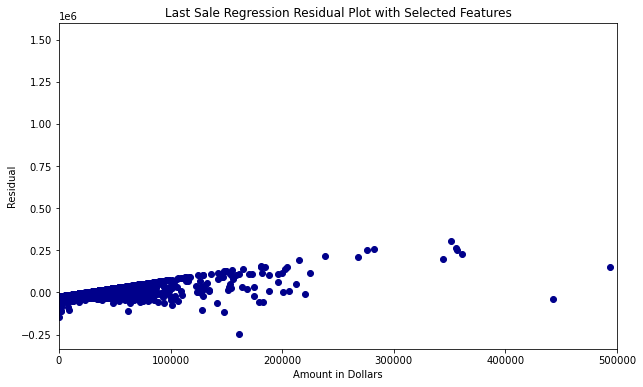

In [40]:
res = y_test - y_pred
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(y_test, res, 'o', color='darkblue')
plt.title("Last Sale Regression Residual Plot with Selected Features")
plt.xlabel("Amount in Dollars")
plt.ylabel("Residual")
plt.xlim(0, 500000)
plt.savefig('Last Sale Regression Residual Plot with Selected Features', transparent=True)
plt.show()
plt.close()